# Homework 4

Raphaël Attali, Camille Morand-Duval, Niels Nicolas, Debdeep Roy

# Twitter sentiment index, index market returns and Granger causality

Financial markets react to news in various ways. The question here is if or how Tweets actually impact a broad stock market index. The May 7, 2019 Wall Steet Journal article ”Stocks Sink as Trade Tensions Mount” writes for example: ”The market will be pretty volatile in the next week or two reacting to headlines and comments and tweets.” Or on May 1, 2020, The Wall Street Journal article heads ’Elon Musk Tweeted That Tesla’s Stock Was Too High. The Market Agreed.’ In order to investigate if such impact is not only anecdotal but also true over longer periods, you will need to create a Twitter  sentiment time series, study its dynamic properties, and relate it to the stock market. The way you construct your sentiment time series is deliberately left to you.

In [2]:
import GetOldTweets3 as got
import pandas as pd
import csv
from datetime import date, timedelta, datetime
import re 
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

## Question 1
Extract from Twitter, daily tweets from people you might think influence the US stock market, e.g. Donald Trump. Note that rather than an index you can also take a stock like Tesla and check Elon Musk’s Tweets. Or aggregate sentiments from various people. Try to go back a couple of years in the past.

### Extract tweets

In [ ]:
with open("data/tesla2.csv", 'w', encoding="utf-8") as f:
    # Wrap the file object by the writer.
    writer = csv.writer(f)
    
    # Write the header line to the output if needed.
    writer.writerow(['date', 'tweet'])
    
    start = date(2020, 5, 22)
    end = date.today()
    day = timedelta(days=1)

    mydate = start
    
    while mydate < end:
        print("{date.day:02}{date.month:02}{date.year}".format(date=mydate))
        
        tweetCriteria = got.manager.TweetCriteria().setUsername('elonmusk')\
                                           .setSince(("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate)))\
                                           .setUntil(("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate+day)))\
                                           .setTopTweets(True)\
                                           .setMaxTweets(240)
        
        mydate = mydate + day
        
    
        # Loop through the dictionary and get the tuples.
        # You may want to sort it somehow. Not shown here.
        for tweets in got.manager.TweetManager.getTweets(tweetCriteria):
            #writer.writerow(t)

            writer.writerow([tweets.date, tweets.text])

### From csv

In [3]:
tweets = pd.read_csv('data/tesla.csv')
tweets.dropna(axis = 0, how ='all', inplace = True)

In [5]:
# convert dates
tweets['date'] = tweets['date'].apply(lambda x: datetime.strptime(x.split(" ")[0], '%Y-%m-%d'))

In [159]:
min(tweets['date'])
tweets['date'].unique().shape

(351,)

### Extract stock values

In [160]:
# import external pandas_datareader library with alias of web
import pandas_datareader as web
 
# import datetime internal datetime module
# datetime is a Python module
import datetime
 
# datetime.datetime is a data type within the datetime module
start = datetime.datetime(2019, 5, 31)
end = datetime.datetime(2020, 6, 21)
 
# DataReader method name is case sensitive
stocks = web.DataReader("tsla", 'yahoo', start, end)

## Question 2
Do the necessary cleaning of the tweets and create a daily sentiment index time series. Explain your approach (number of tweets, number of words per tweets, etc).

#### Comment: 

Method used: 

In [7]:
tweets.head()

,date,tweet
1,2019-06-01,"We’re trying to simplify product complexity, s..."
3,2019-06-01,Science
5,2019-06-01,Read it on @BBCScienceNews
7,2019-06-01,
9,2019-06-02,Exactly


### Import twitter samples for training

In [8]:
nltk.download('twitter_samples')
nltk.download('punkt')
from nltk.corpus import twitter_samples

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

tweet_tokens = twitter_samples.tokenized('positive_tweets.json')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Normalizing

In [9]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Lemmatization

In [10]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

print(tweet_tokens[0])
print(lemmatize_sentence(tweet_tokens[0]))

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']
['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'be', 'top', 'engage', 'member', 'in', 'my', 'community', 'this', 'week', ':)']


### Cleaning

In [11]:
import re, string
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [12]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

print(remove_noise(tweet_tokens[0], stop_words))

['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Apply on training data

In [13]:
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [14]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

### Training & Testing Naive Bayes Classifier for sentiment analysis 

In [15]:
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

In [16]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))

Accuracy is: 0.996
Most Informative Features
                      :( = True           Negati : Positi =   2060.5 : 1.0
                      :) = True           Positi : Negati =   1651.1 : 1.0
                     sad = True           Negati : Positi =     36.4 : 1.0
                follower = True           Positi : Negati =     35.2 : 1.0
                     bam = True           Positi : Negati =     22.5 : 1.0
                 welcome = True           Positi : Negati =     15.7 : 1.0
                followed = True           Negati : Positi =     15.3 : 1.0
               community = True           Positi : Negati =     13.7 : 1.0
                  arrive = True           Positi : Negati =     13.4 : 1.0
                congrats = True           Positi : Negati =     13.1 : 1.0
None


### Application to Elon Musk tweets

In [17]:
#from nltk.tokenize import word_tokenize

#custom_tweet = "I ordered just once from TerribleCo, they screwed up, never used the app again."
#custom_tokens = remove_noise(word_tokenize(custom_tweet))
#dist = classifier.prob_classify(dict([token, True] for token in custom_tokens))

#print(dist.prob("Positive"))
#print(dist.prob("Negative"))

In [18]:
from nltk.tokenize import word_tokenize

def sentiment_analysis(tweet):
    tweet = remove_noise(word_tokenize(str(tweet)))
    dist = classifier.prob_classify(dict([token, True] for token in tweet))
    sentiment = dist.prob("Positive")
    return sentiment

tweets['sentiment'] = tweets['tweet'].apply(lambda x: sentiment_analysis(x))

In [19]:
# length of tweet
tweets['length'] = tweets['tweet'].apply(lambda x: len(str(x).split(" ")))

In [20]:
tweets.head()

,date,tweet,sentiment,length
1,2019-06-01,"We’re trying to simplify product complexity, s...",0.812157,19
3,2019-06-01,Science,0.700000,2
5,2019-06-01,Read it on @BBCScienceNews,0.609375,4
7,2019-06-01,,0.498572,2
9,2019-06-02,Exactly,0.500000,1


### Aggregate per day

In [23]:
import numpy as np
tweets_day = tweets.groupby(['date']).apply(lambda x: pd.Series([np.average(x['sentiment'], weights=x['length'])], index=['sentiment'])).unstack()
tweets_day = pd.DataFrame(tweets_day).reset_index().drop(columns=['level_0']).rename(columns={0: 'score'})

In [27]:
print('max', tweets_day['score'].max())
print('min', tweets_day['score'].min())
print('shape', tweets_day.shape)
tweets_day.head()

max 0.9999310388226771
min 0.036471919389070476
shape (351, 2)


,date,score
0,2019-06-01,0.750579
1,2019-06-02,0.500000
2,2019-06-03,0.174676
3,2019-06-04,0.427268
4,2019-06-05,0.825564


### Sentiment index (score) vs. time

Text(0, 0.5, 'sentiment index')

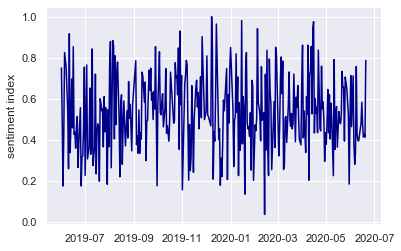

In [28]:
plt.plot(tweets_day['date'],tweets_day['score'], color = 'darkblue')
#plt.xlabel('date')
plt.ylabel('sentiment index')

#### Comment: 
Aggregation and general validity of index

## Question 3
Study the properties of the sentiment index time series, descriptive statistics, ACF, and develop/estimate a time series model for it (AR, MA, ARMA).

### Descriptive statistics

Text(0, 0.5, 'frequency')

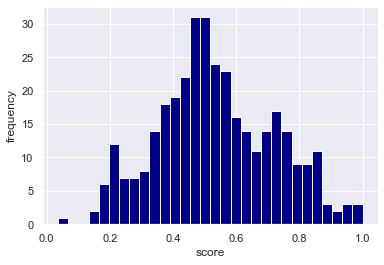

In [29]:
plt.hist(tweets_day['score'], bins = 30, color = 'darkblue')
plt.xlabel('score')
plt.ylabel('frequency')

In [30]:
mean = tweets_day['score'].mean()
variance = tweets_day['score'].var()
skewness = tweets_day['score'].skew()
kurtosis = tweets_day['score'].kurt()

print('mean:', mean) 
print('variance:', variance)
print('skewness:', skewness)
print('kurtosis:', kurtosis)

mean: 0.5334413643874965
variance: 0.0343261313160469
skewness: 0.14705348708639826
kurtosis: -0.3979824466925117


#### Comment 
Descriptive statistics

### ACF

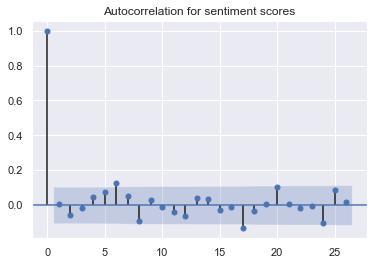

In [79]:
sm.graphics.tsa.plot_acf(tweets_day['score'])
plt.title('Autocorrelation for sentiment scores')
plt.show()

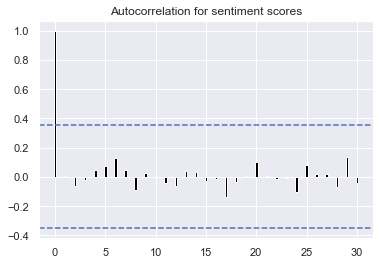

In [47]:
# Jeroen's code - ARMASIM-1
tweets_acf = acf(tweets_day['score'], nlags=30) # doesn't work above 40 (every 10)
x = range(0,31)
plt.bar(x,tweets_acf,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(tweets_acf)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(tweets_acf)),linestyle='--',color='b')
plt.title('Autocorrelation for sentiment scores')
plt.show()

### PACF

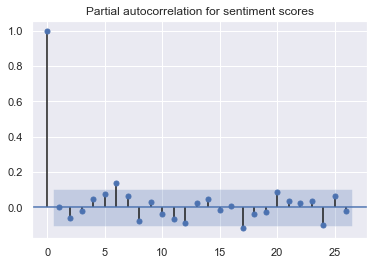

In [78]:
sm.graphics.tsa.plot_pacf(tweets_day['score'])
plt.title('Partial autocorrelation for sentiment scores')
plt.show()

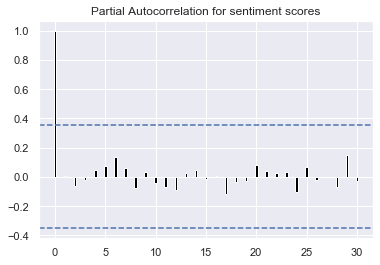

In [49]:
# Jeroen's code - ARMASIM-1
tweets_acf = pacf(tweets_day['score'], nlags=30)
x = range(0,31)
plt.bar(x,tweets_acf,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(tweets_acf)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(tweets_acf)),linestyle='--',color='b')
plt.title('Partial Autocorrelation for sentiment scores')
plt.show()

#### Comment
Conclusion on model to chose

### Model Design

In [85]:
# Jeroen's code - ARMASIM-1
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(tweets_day['score'], order=(0,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  score   No. Observations:                  351
Model:                     ARMA(0, 1)   Log Likelihood                  94.217
Method:                       css-mle   S.D. of innovations              0.185
Date:                Mon, 22 Jun 2020   AIC                           -182.434
Time:                        12:10:28   BIC                           -170.852
Sample:                             0   HQIC                          -177.824
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5334      0.010     53.735      0.000       0.514       0.553
ma.L1.score     0.0053      0.057      0.093      0.926      -0.106       0.117
                                    Roots       

In [86]:
# Jeroen's code - ARMASIM-1
model_fit.params #coef param

const          0.533448
ma.L1.score    0.005291
dtype: float64

In [87]:
model_fit.cov_params() #cov matrix

,const,ma.L1.score
const,0.000099,0.000004
ma.L1.score,0.000004,0.003253


#### Residuals

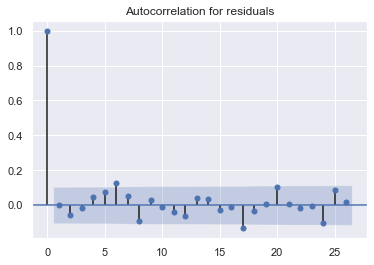

In [88]:
sm.graphics.tsa.plot_acf(model_fit.resid)
plt.title('Autocorrelation for residuals')
plt.show()

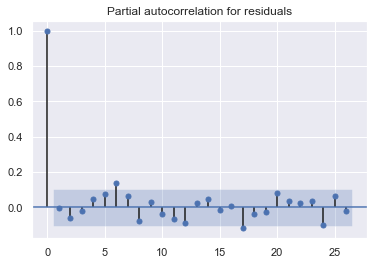

In [89]:
sm.graphics.tsa.plot_pacf(model_fit.resid)
plt.title('Partial autocorrelation for residuals')
plt.show()

### MA(1)

#### Forecast

In [117]:
#forecasting
T = len(tweets_day['score'])
tweet_res = model_fit.resid
tweet_sig2 = model_fit.sigma2
tweet_coef = model_fit.params
theta_1 = tweet_coef[0]
mu = tweet_coef[1]
hor = 2
forecast = np.ones((hor), dtype = float);
forecastvar = np.zeros((hor), dtype = float);
forecast[0] = mu + theta_1 * tweet_res[T - 1]
forecastvar[0] = tweet_sig2

In [118]:
for i in range(1,hor):
    forecast[i]=mu
    forecastvar[i]=tweet_sig2*np.power(1+theta_1,2)

In [119]:
#variables for plot
T0=T-50
y=np.append(tweets_day['score'][T0:T],forecast)
uppr=forecast+2*np.sqrt(forecastvar)
lwr=forecast-2*np.sqrt(forecastvar)
y_up=np.append(tweets_day['score'][T0:T], uppr)
y_lo=np.append(tweets_day['score'][T0:T], lwr)

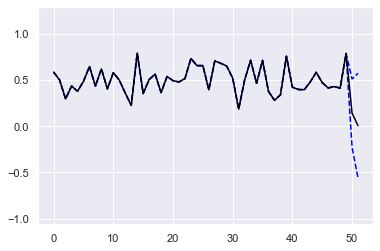

In [120]:
plt.plot(y_lo,color='blue', linestyle='--')
plt.plot(y_up,color='blue', linestyle='--')
plt.plot(y,color='black')


plt.ylim(np.min(y_lo)-0.5, np.max(y_up)+0.5)
plt.show()

### AR

### MA

### ARMA

## Question 4
For the same period as your sentiment time series, download S&P 500 (or stock)
daily closing prices and transform the series into log returns. Make time series plots
and compare with the sentiment series.

In [184]:
# log returns
log_stock = np.log(stocks['Adj Close']) 
log_returns = np.diff(log_stock)*100
log_stock.shape

# stocks
log_returns = pd.DataFrame({'date': stocks.reset_index()['Date'][1:], 'log_returns': log_returns})
log_returns.head()

,date,log_returns
1,2019-06-03,-3.400214
2,2019-06-04,7.857601
3,2019-06-05,1.532612
4,2019-06-06,4.651308
5,2019-06-07,-0.706543


Text(0, 0.5, 'log returns')

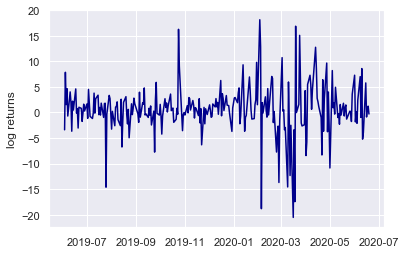

In [187]:
plt.plot(log_returns['date'],log_returns['log_returns'], color = 'darkblue')
#plt.xlabel('date')
plt.ylabel('log returns')

### Time series plots

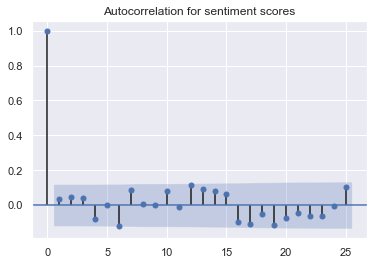

In [190]:
sm.graphics.tsa.plot_acf(log_returns['log_returns'])
plt.title('Autocorrelation for sentiment scores')
plt.show()

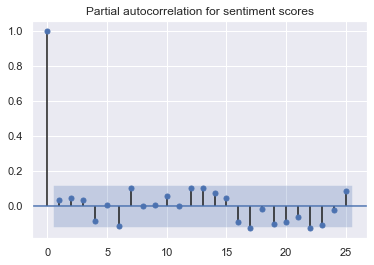

In [189]:
sm.graphics.tsa.plot_pacf(log_returns['log_returns'])
plt.title('Partial autocorrelation for sentiment scores')
plt.show()

#### Comment 
Comparison with sentiment series

## Question 5 
Test for Granger causality between the two time series.

In [ ]:
# stationary test


In [ ]:
data 
gc_res = grangercausalitytests(data, 4)

# Jeroen's code

In [ ]:
### AR-Forecast
import statsmodels.api as sm
import pandas as pd
import datetime
import math
import numpy as np

def AR1_forecast(vy,nfor,hor):
    T = len(vy);
    Tout = round(nfor*T);
    Tin = T-Tout;
    mforecast = np.zeros((Tout,hor), dtype=float); #[]
    mparam = np.zeros((Tout,2), dtype=float); #2 parameters in AR1 model
    for i in range(0,Tout):  #range does not take Tout+1
        vyestim = vy[0:Tin+i];
        Testim = len(vyestim);
        X = np.array(vyestim[i:Testim-1])
        X = sm.add_constant(X)
        Y = np.array(vyestim[i+1:Testim])
        AR1_estim = sm.OLS(Y,X);
        results = AR1_estim.fit()
        mparam[i] = results.params
        vyfor = [1,vyestim[Testim-1]];
        for j in range(0,hor):
            mforecast[i][j] = np.dot(vyfor,mparam[i]);
            vyfor = [1,mforecast[i][j]];
    XX = range(0, Tout)
    plt.scatter(XX,mparam[:,0], s = 15, facecolors = 'none', edgecolors = 'black')
    plt.title('Beta 0')
    plt.show()  

    plt.scatter(XX,mparam[:,1], s = 15, facecolors = 'none', edgecolors = 'black')
    plt.title('Beta 1')
    plt.show()
    return (mforecast)